# 1. Import Libraries

In [1]:
#import libraries

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import pyplot
import seaborn as sns
import numpy as np
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.metrics import classification_report,confusion_matrix,roc_curve,roc_auc_score
from sklearn.metrics import accuracy_score,log_loss
from matplotlib import pyplot
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import cohen_kappa_score
from sklearn.decomposition import PCA

from pprint import pprint
from sklearn.model_selection import RandomizedSearchCV


from sklearn.model_selection import KFold
from sklearn.ensemble import GradientBoostingClassifier

import catboost
from catboost import CatBoostClassifier, Pool, metrics, cv

In [2]:
import warnings
warnings.filterwarnings('ignore')

# 2. Download Data

In [3]:
coffee3 = pd.read_csv('coffee3.csv')

In [4]:
coffee3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         150 non-null    int64  
 1   Country of Origin  150 non-null    object 
 2   Variety            150 non-null    object 
 3   Mean Altitude (m)  150 non-null    float64
 4   Harvest Year       150 non-null    int64  
 5   Processing Method  150 non-null    object 
 6   Moisture           150 non-null    float64
 7   Color              150 non-null    object 
 8   Coffee_Grade       150 non-null    object 
dtypes: float64(2), int64(2), object(5)
memory usage: 10.7+ KB


In [5]:
coffee3 = coffee3.drop(columns=['Unnamed: 0'])

### 2.1 Dealing with categorical, train_test_split and scaling 

First let's get our target feature y and our predictive features X.

In [6]:
X = coffee3.drop('Coffee_Grade', axis=1)
        
y = coffee3['Coffee_Grade']
X.shape, y.shape

((150, 7), (150,))

We will use pandas, get_dummies to encode our categorical data.

In [7]:
X_dumm = pd.get_dummies(X, drop_first=True)
X_dumm.shape

(150, 19)

Now we will split our data in train and test.

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X_dumm, y, test_size = 0.25, random_state=10)

Finally we will apply sklearn's StandardScaler.

In [9]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

### 2.2 Defining useful functions 
Now we will crate a few functions to help us:

 * Getting the Evaluation Metrics from our classification models:
    * Accuracy - for both Train and Test
    * Cohen's Kappa - for both Train and Test
    * Classification report - which includes the F1 score, Recall and Precision for both predicted classes.
    * Confusion matrix - normalized.
    
 * Creating a Results Data Frame
 * Performing a Random Search of Parameters
 * Performing a Grid Search of Parameters

In [10]:
#printing classification report and confusion matrix
def evaluation_block(model):
    global train_acc, test_acc
    
    y_tr_pred = model.predict(X_train)
    
    train_acc = round(accuracy_score(y_train,y_tr_pred),4)
    test_acc = round(accuracy_score(y_test,y_pred),4)
    train_f1 = round(f1_score(y_train, y_tr_pred, average='weighted'),4)
    test_f1 = round(f1_score(y_test, y_pred, average='weighted'),4)
    #train_logloss = round(log_loss(y_train,y_tr_pred),4)
    #test_logloss = round(log_loss(y_test,y_pred),4)
    
    print("Train - Accuracy:", train_acc)
    print("Test - Accuracy:", test_acc)
    print("Train - F1:", train_f1)
    print("Test - F1:", test_f1)
    #print("Train - Log Loss:", train_logloss)
    #print("Test - Log Loss:", test_logloss)

    print('Validation - Classification report\n', classification_report(y_test,y_pred))
    plt.figure(figsize=(9,9))
    plot_confusion_matrix(model, X_test, y_test, normalize='true', cmap = 'Blues')
    plt.show()

In [11]:
#create a dataframe to store and compare our model results
results = pd.DataFrame(columns = ['model','name','train_accuracy', 'test_accuracy', 'train_f1', 'test_f1'])
pd.set_option("max_colwidth", 100)
def save_scores(model, name):
    y_tr_pred = model.predict(X_train)
    
    train_acc = round(accuracy_score(y_train,y_tr_pred),4)
    test_acc = round(accuracy_score(y_test,y_pred),4)
    train_f1 = round(f1_score(y_train, y_tr_pred, average='micro'),4)
    test_f1 = round(f1_score(y_test, y_pred, average='micro'),4)
    #train_cohen = round(cohen_kappa_score(y_train, y_tr_pred),4)
    #test_cohen = round(cohen_kappa_score(y_test, y_pred),4)
    
    new_row = {'model':model,
               'name': name,
               'train_accuracy': train_acc,
               'test_accuracy': test_acc,
               'train_f1': train_f1,
               'test_f1': test_f1,
               #'train_logloss': train_logloss,
               #'test_logloss': test_logloss
              }
    results.loc[0 if pd.isnull(results.index.max()) else results.index.max() + 1] = new_row

In [12]:
#create function to perform random search on a given model and parameter grid
def rand_cv(model, param_grid, name):
    # Random search of parameters, using 3 fold cross validation, 
    random = RandomizedSearchCV(estimator = model, param_distributions = param_grid ,n_iter=100, cv = 3, verbose=2, random_state=10, n_jobs = -1)
    random.fit(X_train, y_train)
    print('Best Parameters based on Randomized Search CV:', random.best_params_)
    print('Best score: ', random.best_score_)
    evaluation_block(random)
    save_scores(random, name)

In [13]:
#create function to perform grid search on a given model and parameter grid
def grid_cv(model, param_grid, name):
    grid = GridSearchCV(model, param_grid, cv = 3)
    grid.fit(X_train, y_train)
    y_pred = grid.predict(X_test)

    print('Best Parameters based on Grid Search CV: ', grid.best_params_)
    print('Best Score: ', grid.best_score_)
    evaluation_block(grid)
    save_scores(grid, name)

# 3. Logistic Regression Model

### 3.1 Logistic Regression - Out of the Box

For our initial model we will start off with logistic regression

In [14]:
logisticRegr = LogisticRegression()
logisticRegr.fit(X_train, y_train)
y_pred = logisticRegr.predict(X_test)

Train - Accuracy: 0.7589
Test - Accuracy: 0.7105
Train - F1: 0.7551
Test - F1: 0.6724
Validation - Classification report
                   precision    recall  f1-score   support

Grade 3 or Lower       0.00      0.00      0.00         2
         Premium       0.69      0.95      0.80        21
       Specialty       0.78      0.47      0.58        15

        accuracy                           0.71        38
       macro avg       0.49      0.47      0.46        38
    weighted avg       0.69      0.71      0.67        38



<Figure size 648x648 with 0 Axes>

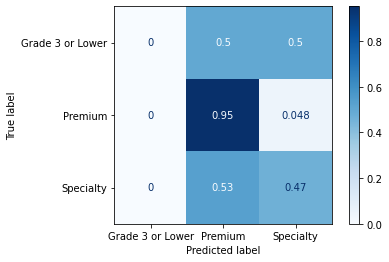

In [15]:
evaluation_block(logisticRegr)

The score for the out of the box LogisticRegression model is: 0.71 accuracy and 0.41 Cohen Kappa score.

In [16]:
save_scores(logisticRegr, 'Log Reg Out of the Box')

In [17]:
results

,model,name,train_accuracy,test_accuracy,train_f1,test_f1
0,LogisticRegression(),Log Reg Out of the Box,0.7589,0.7105,0.7589,0.7105


### 3.2 Logistic regression with PCA

The out of the box model can be improved by either tunning the hyperparameters or by further modifing the data prior to applying the classifiers.

We will now see how PCA affects our LogisticRegression model.

In [18]:
pca = PCA()
pca.fit(X_train)

PCA()

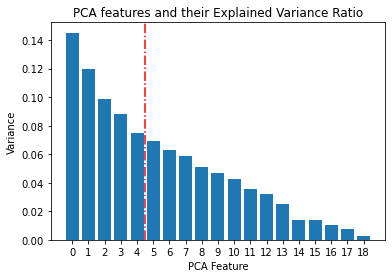

In [19]:
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_)
plt.axvline(4.5, c = 'red', linestyle = '-.')
plt.xticks(features)
plt.ylabel('Variance')
plt.xlabel('PCA Feature')
plt.title('PCA features and their Explained Variance Ratio')
plt.show()

Text(0.5, 1.0, 'Cummulative PCA features with a 50%, 70% 90% and 99% explained variance ratio thresholds" ')

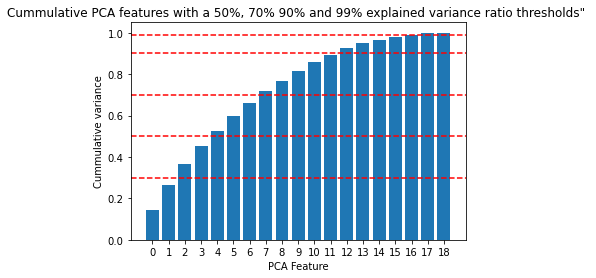

In [20]:
plt.bar(features, np.cumsum(pca.explained_variance_ratio_))
[plt.axhline(y=i, linestyle='--', c = 'red') for i in [.3,.5,.7,.9, 0.99]]
plt.xticks(features)
plt.ylabel('Cummulative variance')
plt.xlabel('PCA Feature')
plt.title('Cummulative PCA features with a 50%, 70% 90% and 99% explained variance ratio thresholds" ')

Based on our PCA decomposition we can choose the folowing number of principal components:

* 2 - for about 30% explained variance
* 4 - for >50% explained variance
* 7 - for >70% explained variance
* 12 - for >90% explained variance
* 17 - for >99% explained variance

Obviously we need to consider the fact that a model based on fewer features will be underfitting while one based on a lot of them will ussualy overfit.

Another aspect when considering underfitting vs overfitting is the dataset size, and in this case the training data has barely over 100 records, so considering we are dealing with a rather small dataset we can can't choose more features without a high risk of overfitting. We will check that by comparing the metrics from our training set versus the scores our models produces on the test set.

---------------------Train & Test scores : Log reg model with 2 PCA features-------------------
Train - Accuracy:  0.5089
Test - Accuracy:  0.6316
Train - F1: 0.4724 
Test - F1: 0.5834 

                  precision    recall  f1-score   support

Grade 3 or Lower       0.00      0.00      0.00         2
         Premium       0.63      0.90      0.75        21
       Specialty       0.62      0.33      0.43        15

        accuracy                           0.63        38
       macro avg       0.42      0.41      0.39        38
    weighted avg       0.60      0.63      0.58        38



<Figure size 648x648 with 0 Axes>

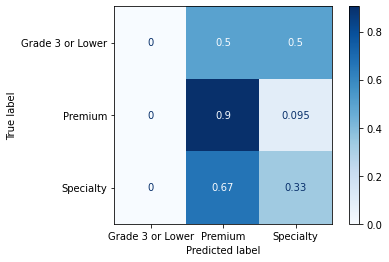

---------------------Train & Test scores : Log reg model with 4 PCA features-------------------
Train - Accuracy:  0.6429
Test - Accuracy:  0.6579
Train - F1: 0.6084 
Test - F1: 0.627 

                  precision    recall  f1-score   support

Grade 3 or Lower       0.00      0.00      0.00         2
         Premium       0.67      0.86      0.75        21
       Specialty       0.64      0.47      0.54        15

        accuracy                           0.66        38
       macro avg       0.43      0.44      0.43        38
    weighted avg       0.62      0.66      0.63        38



<Figure size 648x648 with 0 Axes>

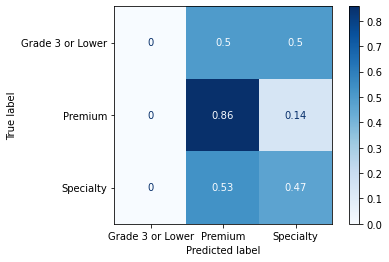

---------------------Train & Test scores : Log reg model with 7 PCA features-------------------
Train - Accuracy:  0.6786
Test - Accuracy:  0.6579
Train - F1: 0.6455 
Test - F1: 0.6431 

                  precision    recall  f1-score   support

Grade 3 or Lower       0.00      0.00      0.00         2
         Premium       0.71      0.81      0.76        21
       Specialty       0.62      0.53      0.57        15

        accuracy                           0.66        38
       macro avg       0.44      0.45      0.44        38
    weighted avg       0.63      0.66      0.64        38



<Figure size 648x648 with 0 Axes>

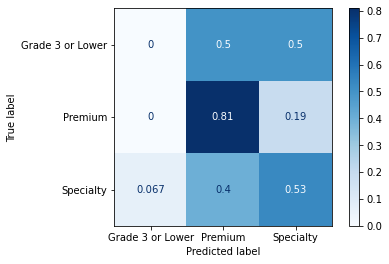

---------------------Train & Test scores : Log reg model with 12 PCA features-------------------
Train - Accuracy:  0.7232
Test - Accuracy:  0.6316
Train - F1: 0.7206 
Test - F1: 0.6222 

                  precision    recall  f1-score   support

Grade 3 or Lower       0.00      0.00      0.00         2
         Premium       0.71      0.81      0.76        21
       Specialty       0.58      0.47      0.52        15

        accuracy                           0.63        38
       macro avg       0.43      0.43      0.42        38
    weighted avg       0.62      0.63      0.62        38



<Figure size 648x648 with 0 Axes>

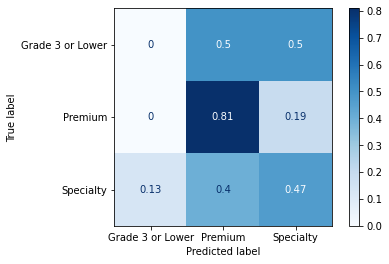

---------------------Train & Test scores : Log reg model with 17 PCA features-------------------
Train - Accuracy:  0.75
Test - Accuracy:  0.6579
Train - F1: 0.7464 
Test - F1: 0.6174 

                  precision    recall  f1-score   support

Grade 3 or Lower       0.00      0.00      0.00         2
         Premium       0.66      0.90      0.76        21
       Specialty       0.67      0.40      0.50        15

        accuracy                           0.66        38
       macro avg       0.44      0.43      0.42        38
    weighted avg       0.63      0.66      0.62        38



<Figure size 648x648 with 0 Axes>

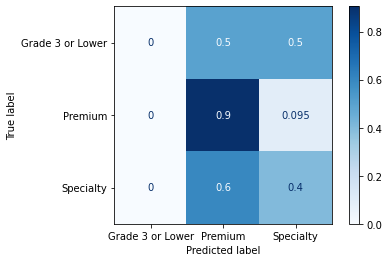

In [21]:
pca_feat = [2,4,7,12,17]
for i in pca_feat:
    pca = PCA(n_components = i)
    pca.fit(X_train)
    X_train_i = pca.transform(X_train)
    X_test_i = pca.transform(X_test)

    logreg_model = LogisticRegression(max_iter=10000)
    logreg_model.fit(X_train_i, y_train)
    
    y_tr_pred = logreg_model.predict(X_train_i)
    y_tr_pred_prob = logreg_model.predict_proba(X_train_i)[:,1]
    
    y_pred = logreg_model.predict(X_test_i)
    y_pred_prob = logreg_model.predict_proba(X_test_i)[:,1]
    
    #add to results data frame
    train_acc = round(accuracy_score(y_train,y_tr_pred),4)
    test_acc = round(accuracy_score(y_test,y_pred),4)
    train_f1 = round(f1_score(y_train, y_tr_pred, average='weighted'),4)
    test_f1 = round(f1_score(y_test, y_pred, average='weighted'),4)
    model = logreg_model
    name = 'Log reg model with {} PCA features'.format(i)
    
    new_row = {'model':model,
               'name': name,
               'train_accuracy': train_acc,
               'test_accuracy': test_acc,
               'train_f1': train_f1,
               'test_f1': test_f1}
    results.loc[0 if pd.isnull(results.index.max()) else results.index.max() + 1] = new_row
    
    print('---------------------Train & Test scores : Log reg model with {} PCA features-------------------'.format(i))
    print('Train - Accuracy: ', round(accuracy_score(y_train,y_tr_pred),4))
    print('Test - Accuracy: ', round(accuracy_score(y_test,y_pred),4))
    print('Train - F1: {} '.format(round(f1_score(y_train, y_tr_pred, average='weighted'),4)))        
    print('Test - F1: {} \n'.format(round(f1_score(y_test, y_pred, average='weighted'),4)))
    print(classification_report(y_test,y_pred))
    plt.figure(figsize=(9,9))
    plot_confusion_matrix(logreg_model, X_test_i, y_test, normalize='true', cmap = 'Blues')
    plt.show()
    
    
    
    

In [22]:
results.sort_values('test_accuracy', ascending = False).head(15)

,model,name,train_accuracy,test_accuracy,train_f1,test_f1
0,LogisticRegression(),Log Reg Out of the Box,0.7589,0.7105,0.7589,0.7105
2,LogisticRegression(max_iter=10000),Log reg model with 4 PCA features,0.6429,0.6579,0.6084,0.6270
3,LogisticRegression(max_iter=10000),Log reg model with 7 PCA features,0.6786,0.6579,0.6455,0.6431
5,LogisticRegression(max_iter=10000),Log reg model with 17 PCA features,0.7500,0.6579,0.7464,0.6174
1,LogisticRegression(max_iter=10000),Log reg model with 2 PCA features,0.5089,0.6316,0.4724,0.5834
4,LogisticRegression(max_iter=10000),Log reg model with 12 PCA features,0.7232,0.6316,0.7206,0.6222


As we can see, changing the number of PCA features does not improve the accuracy of our model so for our further modeling we will keep our data without the PCA transformation.

### 3.3 Tuning Hyperparameters of Logistic Regression with GridSearch

Let's first look at the list of parameters currently in use by our base logisic regression model

In [23]:
#Check out parameters currently in use
print('Parameters currently in use:\n')
pprint(logisticRegr.get_params())

Parameters currently in use:

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}


Next we will create a parameter grid of all the parameters we'd like to test and perform our grid search.

In [24]:
param_grid = { 'solver' : ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
                'penalty' : ['none','l1', 'l2', 'elasticnet'],
                'C' : [100, 10, 1.0, 0.1, 0.01],
               'max_iter' : [10, 100, 1000, 10000]
             }

Best Parameters based on Grid Search CV:  {'C': 10, 'max_iter': 10, 'penalty': 'none', 'solver': 'sag'}
Best Score:  0.6258890469416786
Train - Accuracy: 0.7589
Test - Accuracy: 0.6579
Train - F1: 0.7548
Test - F1: 0.6174
Validation - Classification report
                   precision    recall  f1-score   support

Grade 3 or Lower       0.00      0.00      0.00         2
         Premium       0.66      0.90      0.76        21
       Specialty       0.67      0.40      0.50        15

        accuracy                           0.66        38
       macro avg       0.44      0.43      0.42        38
    weighted avg       0.63      0.66      0.62        38



<Figure size 648x648 with 0 Axes>

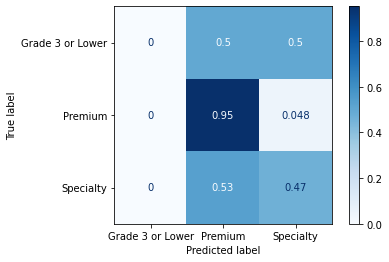

In [25]:
grid_cv(logisticRegr, param_grid, 'Log Reg w/ GridSearch')

Based on our results, the hypertuned model performed worse than our base model.

In [26]:
results.sort_values('test_accuracy', ascending = False).head(15)

,model,name,train_accuracy,test_accuracy,train_f1,test_f1
0,LogisticRegression(),Log Reg Out of the Box,0.7589,0.7105,0.7589,0.7105
2,LogisticRegression(max_iter=10000),Log reg model with 4 PCA features,0.6429,0.6579,0.6084,0.6270
3,LogisticRegression(max_iter=10000),Log reg model with 7 PCA features,0.6786,0.6579,0.6455,0.6431
5,LogisticRegression(max_iter=10000),Log reg model with 17 PCA features,0.7500,0.6579,0.7464,0.6174
6,"GridSearchCV(cv=3, estimator=LogisticRegression(),\n param_grid={'C': [100, 10, 1.0,...",Log Reg w/ GridSearch,0.7589,0.6579,0.7589,0.6579
1,LogisticRegression(max_iter=10000),Log reg model with 2 PCA features,0.5089,0.6316,0.4724,0.5834
4,LogisticRegression(max_iter=10000),Log reg model with 12 PCA features,0.7232,0.6316,0.7206,0.6222


# 4. Random Forest Classifier

### 4.1 Random Forest Classifier - Out of the Box

In [27]:
rfc = RandomForestClassifier(random_state=10)
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)

Train - Accuracy: 0.9911
Test - Accuracy: 0.8421
Train - F1: 0.9909
Test - F1: 0.8451
Validation - Classification report
                   precision    recall  f1-score   support

Grade 3 or Lower       0.33      0.50      0.40         2
         Premium       0.87      0.95      0.91        21
       Specialty       0.92      0.73      0.81        15

        accuracy                           0.84        38
       macro avg       0.71      0.73      0.71        38
    weighted avg       0.86      0.84      0.85        38



<Figure size 648x648 with 0 Axes>

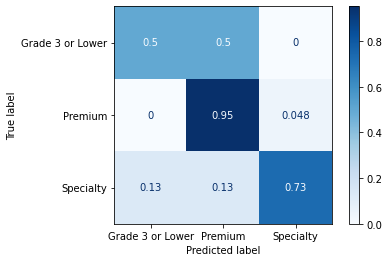

In [28]:
evaluation_block(rfc)

Right off the bat we see a huge improvement in the evaluation metrics for this model compared to the logistic regression model.

In [29]:
save_scores(rfc, 'Random Forest Out of the Box')

In [30]:
results.sort_values('test_accuracy', ascending = False).head(15)

,model,name,train_accuracy,test_accuracy,train_f1,test_f1
7,"(DecisionTreeClassifier(max_features='auto', random_state=1165313289), DecisionTreeClassifier(ma...",Random Forest Out of the Box,0.9911,0.8421,0.9911,0.8421
0,LogisticRegression(),Log Reg Out of the Box,0.7589,0.7105,0.7589,0.7105
2,LogisticRegression(max_iter=10000),Log reg model with 4 PCA features,0.6429,0.6579,0.6084,0.6270
3,LogisticRegression(max_iter=10000),Log reg model with 7 PCA features,0.6786,0.6579,0.6455,0.6431
5,LogisticRegression(max_iter=10000),Log reg model with 17 PCA features,0.7500,0.6579,0.7464,0.6174
6,"GridSearchCV(cv=3, estimator=LogisticRegression(),\n param_grid={'C': [100, 10, 1.0,...",Log Reg w/ GridSearch,0.7589,0.6579,0.7589,0.6579
1,LogisticRegression(max_iter=10000),Log reg model with 2 PCA features,0.5089,0.6316,0.4724,0.5834
4,LogisticRegression(max_iter=10000),Log reg model with 12 PCA features,0.7232,0.6316,0.7206,0.6222


### 4.2 Accounting for Imbalanced Data Set

Because our data classes are highly imbalanced, I want to test some hyperparameters to account for this. We will try 2 different iterations of our RandomForestClassifier model by adjusting the class_weight  

#### 4.2a Random Forest With Class Weighting


In [31]:
rfc_balanced = RandomForestClassifier(class_weight='balanced', random_state = 10)
rfc_balanced.fit(X_train, y_train)
y_pred = rfc_balanced.predict(X_test)

Train - Accuracy: 0.9911
Test - Accuracy: 0.8421
Train - F1: 0.9912
Test - F1: 0.837
Validation - Classification report
                   precision    recall  f1-score   support

Grade 3 or Lower       0.67      1.00      0.80         2
         Premium       0.83      0.95      0.89        21
       Specialty       0.91      0.67      0.77        15

        accuracy                           0.84        38
       macro avg       0.80      0.87      0.82        38
    weighted avg       0.85      0.84      0.84        38



<Figure size 648x648 with 0 Axes>

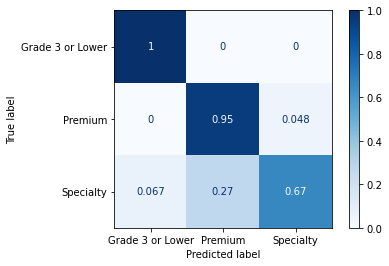

In [32]:
evaluation_block(rfc_balanced)

In [33]:
save_scores(rfc_balanced, 'Random Forest Balanced')

#### 4.2b Random Forest With Bootstrap Class Weighting

In [34]:
rfc_balanced_subsample = RandomForestClassifier(class_weight='balanced_subsample', random_state = 10)
rfc_balanced_subsample.fit(X_train, y_train)
y_pred = rfc_balanced_subsample.predict(X_test)

Train - Accuracy: 0.9911
Test - Accuracy: 0.8421
Train - F1: 0.9912
Test - F1: 0.8411
Validation - Classification report
                   precision    recall  f1-score   support

Grade 3 or Lower       0.50      1.00      0.67         2
         Premium       0.87      0.95      0.91        21
       Specialty       0.91      0.67      0.77        15

        accuracy                           0.84        38
       macro avg       0.76      0.87      0.78        38
    weighted avg       0.87      0.84      0.84        38



<Figure size 648x648 with 0 Axes>

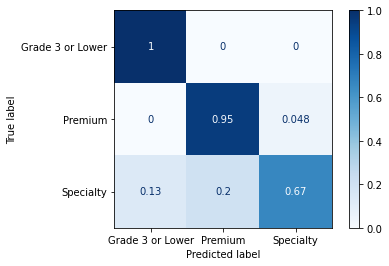

In [35]:
evaluation_block(rfc_balanced_subsample)

In [36]:
save_scores(rfc_balanced_subsample, 'Random Forest Balanced Subsample')

#### 4.2c Random Forest With Random Undersampling

In [37]:
brfc = BalancedRandomForestClassifier(random_state = 10)
brfc.fit(X_train, y_train)
y_pred = brfc.predict(X_test)

Train - Accuracy: 0.7679
Test - Accuracy: 0.6053
Train - F1: 0.7747
Test - F1: 0.6225
Validation - Classification report
                   precision    recall  f1-score   support

Grade 3 or Lower       0.25      1.00      0.40         2
         Premium       0.78      0.67      0.72        21
       Specialty       0.58      0.47      0.52        15

        accuracy                           0.61        38
       macro avg       0.54      0.71      0.55        38
    weighted avg       0.67      0.61      0.62        38



<Figure size 648x648 with 0 Axes>

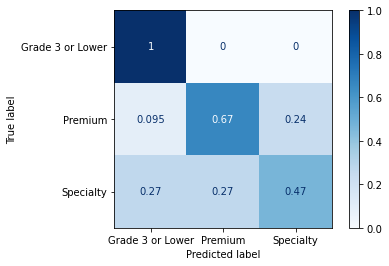

In [38]:
evaluation_block(brfc)

In [39]:
save_scores(brfc, 'Balanced Random Forest Classifier')

In [40]:
results.sort_values('test_accuracy', ascending = False).head(15)

,model,name,train_accuracy,test_accuracy,train_f1,test_f1
7,"(DecisionTreeClassifier(max_features='auto', random_state=1165313289), DecisionTreeClassifier(ma...",Random Forest Out of the Box,0.9911,0.8421,0.9911,0.8421
8,"(DecisionTreeClassifier(max_features='auto', random_state=1165313289), DecisionTreeClassifier(ma...",Random Forest Balanced,0.9911,0.8421,0.9911,0.8421
9,"(DecisionTreeClassifier(max_features='auto', random_state=1165313289), DecisionTreeClassifier(ma...",Random Forest Balanced Subsample,0.9911,0.8421,0.9911,0.8421
0,LogisticRegression(),Log Reg Out of the Box,0.7589,0.7105,0.7589,0.7105
2,LogisticRegression(max_iter=10000),Log reg model with 4 PCA features,0.6429,0.6579,0.6084,0.6270
3,LogisticRegression(max_iter=10000),Log reg model with 7 PCA features,0.6786,0.6579,0.6455,0.6431
5,LogisticRegression(max_iter=10000),Log reg model with 17 PCA features,0.7500,0.6579,0.7464,0.6174
6,"GridSearchCV(cv=3, estimator=LogisticRegression(),\n param_grid={'C': [100, 10, 1.0,...",Log Reg w/ GridSearch,0.7589,0.6579,0.7589,0.6579
1,LogisticRegression(max_iter=10000),Log reg model with 2 PCA features,0.5089,0.6316,0.4724,0.5834
4,LogisticRegression(max_iter=10000),Log reg model with 12 PCA features,0.7232,0.6316,0.7206,0.6222


Based on these three models, our rfc_balanced_subsample model performed the best.

### 4.3 Tuning Hyperparameters of the Random Forest Classifier

In [41]:
#Check out parameters currently in use
print('Parameters currently in use:\n')
pprint(rfc_balanced_subsample.get_params())

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': 'balanced_subsample',
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 10,
 'verbose': 0,
 'warm_start': False}


### We will try to fine tune the following:

n_estimators = number of trees in the foreset

max_features = max number of features considered for splitting a node

max_depth = max number of levels in each decision tree

min_samples_split = min number of data points placed in a node before the node is split

min_samples_leaf = min number of data points allowed in a leaf node

bootstrap = method for sampling data points (with or without replacement)

### Use Randomized Search to find best parameters

In [42]:
param_grid = {   'bootstrap': [True, False],
                 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
                 'max_features': ['auto', 'sqrt'],
                 'min_samples_leaf': [1, 2, 4],
                 'min_samples_split': [2, 5, 10],
                 'n_estimators': [100,200,300,400,500,600,700,800,900,1000,1100,1200,1300,1400,1500,1600,1700,1800,1900,2000]
             }

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Best Parameters based on Randomized Search CV: {'n_estimators': 1400, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 10, 'bootstrap': True}
Best score:  0.7238027501185397
Train - Accuracy: 0.7857
Test - Accuracy: 0.6053
Train - F1: 0.7849
Test - F1: 0.6225
Validation - Classification report
                   precision    recall  f1-score   support

Grade 3 or Lower       0.25      1.00      0.40         2
         Premium       0.78      0.67      0.72        21
       Specialty       0.58      0.47      0.52        15

        accuracy                           0.61        38
       macro avg       0.54      0.71      0.55        38
    weighted avg       0.67      0.61      0.62        38



<Figure size 648x648 with 0 Axes>

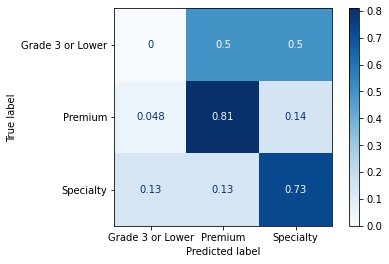

In [43]:
rand_cv(rfc_balanced_subsample, param_grid, 'Random Forest Balanced Subsample RandomSearch')

In [44]:
results.sort_values('test_accuracy', ascending = False).head(15)

,model,name,train_accuracy,test_accuracy,train_f1,test_f1
7,"(DecisionTreeClassifier(max_features='auto', random_state=1165313289), DecisionTreeClassifier(ma...",Random Forest Out of the Box,0.9911,0.8421,0.9911,0.8421
8,"(DecisionTreeClassifier(max_features='auto', random_state=1165313289), DecisionTreeClassifier(ma...",Random Forest Balanced,0.9911,0.8421,0.9911,0.8421
9,"(DecisionTreeClassifier(max_features='auto', random_state=1165313289), DecisionTreeClassifier(ma...",Random Forest Balanced Subsample,0.9911,0.8421,0.9911,0.8421
0,LogisticRegression(),Log Reg Out of the Box,0.7589,0.7105,0.7589,0.7105
2,LogisticRegression(max_iter=10000),Log reg model with 4 PCA features,0.6429,0.6579,0.6084,0.6270
3,LogisticRegression(max_iter=10000),Log reg model with 7 PCA features,0.6786,0.6579,0.6455,0.6431
5,LogisticRegression(max_iter=10000),Log reg model with 17 PCA features,0.7500,0.6579,0.7464,0.6174
6,"GridSearchCV(cv=3, estimator=LogisticRegression(),\n param_grid={'C': [100, 10, 1.0,...",Log Reg w/ GridSearch,0.7589,0.6579,0.7589,0.6579
1,LogisticRegression(max_iter=10000),Log reg model with 2 PCA features,0.5089,0.6316,0.4724,0.5834
4,LogisticRegression(max_iter=10000),Log reg model with 12 PCA features,0.7232,0.6316,0.7206,0.6222


### 4.2 Finding Important Features

In [45]:
#Finding Important Features:
feature_imp = pd.Series(rfc_balanced_subsample.feature_importances_,index=X_dumm.columns).sort_values(ascending=False)
feature_imp

Moisture                                    0.274933
Mean Altitude (m)                           0.245325
Country of Origin_Other                     0.078774
Harvest Year                                0.072863
Country of Origin_Guatemala                 0.046343
Color_Green                                 0.038808
Processing Method_Washed / Wet              0.037686
Variety_Caturra                             0.031663
Variety_Other                               0.031487
Variety_Catuai                              0.027435
Country of Origin_Ethiopia                  0.023493
Country of Origin_Colombia                  0.021414
Color_None                                  0.018225
Variety_SL28                                0.013473
Processing Method_Pulped natural / honey    0.009804
Country of Origin_Costa Rica                0.009150
Color_Yellow-Green                          0.009103
Color_Greenish                              0.007427
Processing Method_Other                     0.

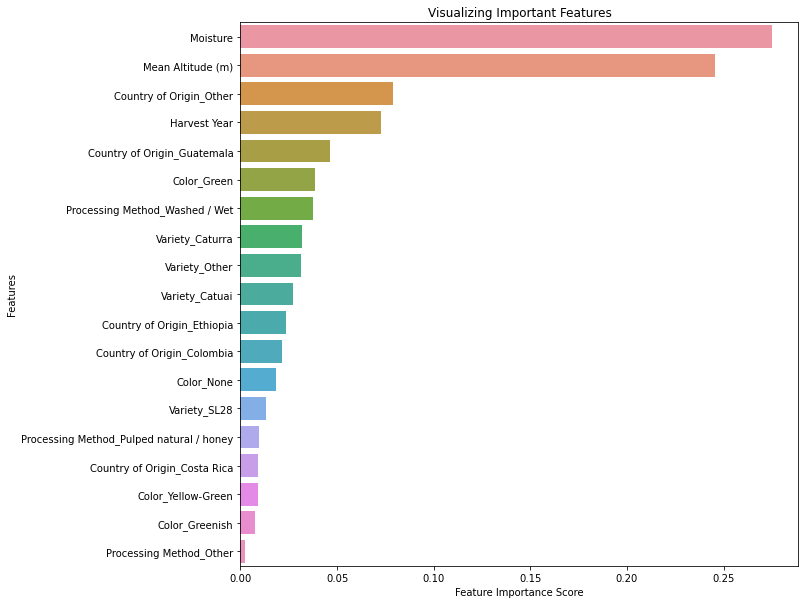

In [46]:
#Visualizing Important Features

%matplotlib inline
# Creating a bar plot
fig, ax = plt.subplots(figsize=(10,10))
sns.barplot(x=feature_imp, y=feature_imp.index)

# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()

In [47]:
#sorting features by importance
feat_sorted_idx = np.argsort(feature_imp)

In [48]:
# Choosing most important top 4,9,and 13 features.
top2_feat = X_dumm.columns[feat_sorted_idx][-2:]
top4_feat = X_dumm.columns[feat_sorted_idx][-4:]
top10_feat = X_dumm.columns[feat_sorted_idx][-10:]
top2_feat, top4_feat, top10_feat

(Index(['Harvest Year', 'Mean Altitude (m)'], dtype='object'),
 Index(['Country of Origin_Colombia', 'Moisture', 'Harvest Year',
        'Mean Altitude (m)'],
       dtype='object'),
 Index(['Variety_Caturra', 'Variety_Catuai', 'Country of Origin_Other',
        'Country of Origin_Guatemala', 'Country of Origin_Ethiopia',
        'Country of Origin_Costa Rica', 'Country of Origin_Colombia',
        'Moisture', 'Harvest Year', 'Mean Altitude (m)'],
       dtype='object'))

In [49]:
print('The Predictive features subsets have {}, {}, and {} features respectively.'.format(len(top2_feat), len(top4_feat), len(top10_feat)))

The Predictive features subsets have 2, 4, and 10 features respectively.


----------Random forest model on train set with 2 most important features-------
RandomForestClassifier(random_state=10)
Train - Accuracy: 0.8393
Test - Accuracy: 0.6842
Validation - Classification report
                   precision    recall  f1-score   support

Grade 3 or Lower       0.50      0.50      0.50         4
         Premium       0.76      0.73      0.74        22
       Specialty       0.62      0.67      0.64        12

        accuracy                           0.68        38
       macro avg       0.63      0.63      0.63        38
    weighted avg       0.69      0.68      0.69        38



<Figure size 648x648 with 0 Axes>

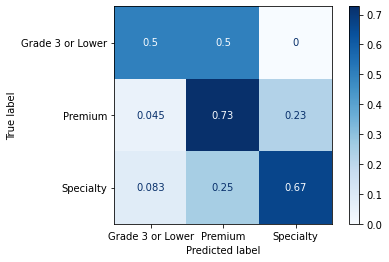

Train Cohen Kappa: 0.7081
Test Cohen Kappa: 0.437
RandomForestClassifier(class_weight='balanced_subsample', random_state=10)
Train - Accuracy: 0.8393
Test - Accuracy: 0.6579
Validation - Classification report
                   precision    recall  f1-score   support

Grade 3 or Lower       0.33      0.50      0.40         4
         Premium       0.73      0.73      0.73        22
       Specialty       0.70      0.58      0.64        12

        accuracy                           0.66        38
       macro avg       0.59      0.60      0.59        38
    weighted avg       0.68      0.66      0.66        38



<Figure size 648x648 with 0 Axes>

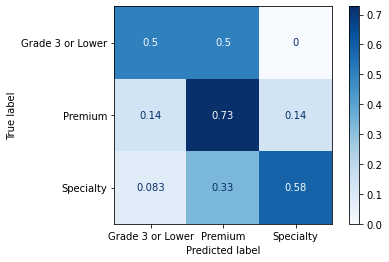

Train Cohen Kappa: 0.7215
Test Cohen Kappa: 0.3946
----------Random forest model on train set with 4 most important features-------
RandomForestClassifier(random_state=10)
Train - Accuracy: 0.9464
Test - Accuracy: 0.7368
Validation - Classification report
                   precision    recall  f1-score   support

Grade 3 or Lower       1.00      0.25      0.40         4
         Premium       0.83      0.83      0.83        23
       Specialty       0.57      0.73      0.64        11

        accuracy                           0.74        38
       macro avg       0.80      0.60      0.62        38
    weighted avg       0.77      0.74      0.73        38



<Figure size 648x648 with 0 Axes>

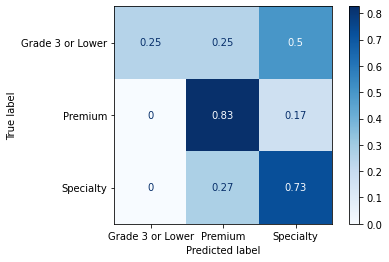

Train Cohen Kappa: 0.9063
Test Cohen Kappa: 0.498
RandomForestClassifier(class_weight='balanced_subsample', random_state=10)
Train - Accuracy: 0.9464
Test - Accuracy: 0.7105
Validation - Classification report
                   precision    recall  f1-score   support

Grade 3 or Lower       0.67      0.50      0.57         4
         Premium       0.85      0.74      0.79        23
       Specialty       0.53      0.73      0.62        11

        accuracy                           0.71        38
       macro avg       0.68      0.66      0.66        38
    weighted avg       0.74      0.71      0.72        38



<Figure size 648x648 with 0 Axes>

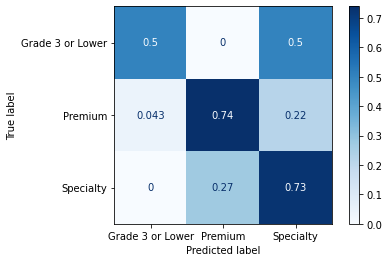

Train Cohen Kappa: 0.9063
Test Cohen Kappa: 0.482
----------Random forest model on train set with 10 most important features-------
RandomForestClassifier(random_state=10)
Train - Accuracy: 0.9821
Test - Accuracy: 0.7895
Validation - Classification report
                   precision    recall  f1-score   support

Grade 3 or Lower       0.67      1.00      0.80         2
         Premium       0.87      0.72      0.79        18
       Specialty       0.75      0.83      0.79        18

        accuracy                           0.79        38
       macro avg       0.76      0.85      0.79        38
    weighted avg       0.80      0.79      0.79        38



<Figure size 648x648 with 0 Axes>

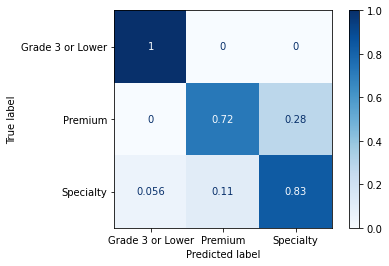

Train Cohen Kappa: 0.9688
Test Cohen Kappa: 0.6238
RandomForestClassifier(class_weight='balanced_subsample', random_state=10)
Train - Accuracy: 0.9821
Test - Accuracy: 0.7105
Validation - Classification report
                   precision    recall  f1-score   support

Grade 3 or Lower       0.67      1.00      0.80         2
         Premium       0.72      0.72      0.72        18
       Specialty       0.71      0.67      0.69        18

        accuracy                           0.71        38
       macro avg       0.70      0.80      0.74        38
    weighted avg       0.71      0.71      0.71        38



<Figure size 648x648 with 0 Axes>

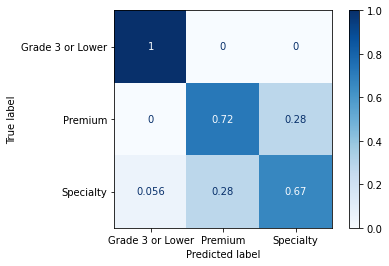

Train Cohen Kappa: 0.9688
Test Cohen Kappa: 0.4827


In [50]:
def selecting_features():
    for columns_set in [top2_feat, top4_feat, top10_feat]:
        X = X_dumm[columns_set]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)
        print('----------Random forest model on train set with {} most important features-------'.format(len(columns_set)))
        for rfc_model in [rfc, rfc_balanced_subsample]:
            print(rfc_model)
            rfc_model.fit(X_train, y_train)
            y_pred = rfc_model.predict(X_test)
            
            y_tr_pred = rfc_model.predict(X_train)
    
            train_acc = round(accuracy_score(y_train,y_tr_pred),4)
            test_acc = round(accuracy_score(y_test,y_pred),4)
    
            print("Train - Accuracy:", train_acc)
            print("Test - Accuracy:", test_acc)
            print('Validation - Classification report\n', classification_report(y_test,y_pred))
            plt.figure(figsize=(9,9))
            plot_confusion_matrix(rfc_model, X_test, y_test, normalize='true', cmap = 'Blues')
            plt.show()
            
            y_pred_prob = rfc_model.predict_proba(X_test)[:,1]
            y_tr_pred_prob = rfc_model.predict_proba(X_train)[:,1]
            
            train_cohen = round(cohen_kappa_score(y_train, y_tr_pred),4)
            test_cohen = round(cohen_kappa_score(y_test, y_pred),4)
        
            #train_roc_score = round(roc_auc_score(y_train, y_tr_pred_prob),4)
            #test_roc_score = round(roc_auc_score(y_test, y_pred_prob),4)
        
            print('Train Cohen Kappa: {}'.format(train_cohen))
            print('Test Cohen Kappa: {}'.format(test_cohen))
            
            name = '{} with top {} features'.format(rfc_model, columns_set)
        
            new_row = {'model':rfc_model,
                       'name': name,
               'train_accuracy': train_acc,
               'test_accuracy': test_acc,
               'train_cohenkappa': train_cohen,
               'test_cohenkappa': test_cohen}
            results.loc[0 if pd.isnull(results.index.max()) else results.index.max() + 1] = new_row
            
selecting_features()

In [51]:
results.sort_values('test_accuracy', ascending = False).head(15)

,model,name,train_accuracy,test_accuracy,train_f1,test_f1
9,"(DecisionTreeClassifier(max_features='auto', random_state=1165313289), DecisionTreeClassifier(ma...",Random Forest Balanced Subsample,0.9911,0.8421,0.9911,0.8421
7,"(DecisionTreeClassifier(max_features='auto', random_state=1165313289), DecisionTreeClassifier(ma...",Random Forest Out of the Box,0.9911,0.8421,0.9911,0.8421
8,"(DecisionTreeClassifier(max_features='auto', random_state=1165313289), DecisionTreeClassifier(ma...",Random Forest Balanced,0.9911,0.8421,0.9911,0.8421
16,"(DecisionTreeClassifier(max_features='auto', random_state=1165313289), DecisionTreeClassifier(ma...","RandomForestClassifier(random_state=10) with top Index(['Variety_Caturra', 'Variety_Catuai', 'Co...",0.9821,0.7895,NaN,NaN
14,"(DecisionTreeClassifier(max_features='auto', random_state=1165313289), DecisionTreeClassifier(ma...","RandomForestClassifier(random_state=10) with top Index(['Country of Origin_Colombia', 'Moisture'...",0.9464,0.7368,NaN,NaN
15,"(DecisionTreeClassifier(max_features='auto', random_state=1165313289), DecisionTreeClassifier(ma...","RandomForestClassifier(class_weight='balanced_subsample', random_state=10) with top Index(['Coun...",0.9464,0.7105,NaN,NaN
0,LogisticRegression(),Log Reg Out of the Box,0.7589,0.7105,0.7589,0.7105
17,"(DecisionTreeClassifier(max_features='auto', random_state=1165313289), DecisionTreeClassifier(ma...","RandomForestClassifier(class_weight='balanced_subsample', random_state=10) with top Index(['Vari...",0.9821,0.7105,NaN,NaN
12,"(DecisionTreeClassifier(max_features='auto', random_state=1165313289), DecisionTreeClassifier(ma...","RandomForestClassifier(random_state=10) with top Index(['Harvest Year', 'Mean Altitude (m)'], dt...",0.8393,0.6842,NaN,NaN
6,"GridSearchCV(cv=3, estimator=LogisticRegression(),\n param_grid={'C': [100, 10, 1.0,...",Log Reg w/ GridSearch,0.7589,0.6579,0.7589,0.6579


Based on our results, reducing the number of features does not give a better model performance. 

# 5. Gradient Boosting Model

Pros: 
    good for heterogeneous data
    easy to use
    works well for small data
    

### 5.1 Gradient Boosting Model - Out of the Box

In [52]:
gbc = GradientBoostingClassifier()
gbc.fit(X_train,y_train)
y_pred = gbc.predict(X_test)

Train - Accuracy: 0.9732
Test - Accuracy: 0.7895
Train - F1: 0.9731
Test - F1: 0.7867
Validation - Classification report
                   precision    recall  f1-score   support

Grade 3 or Lower       1.00      0.50      0.67         2
         Premium       0.78      0.86      0.82        21
       Specialty       0.79      0.73      0.76        15

        accuracy                           0.79        38
       macro avg       0.86      0.70      0.75        38
    weighted avg       0.80      0.79      0.79        38



<Figure size 648x648 with 0 Axes>

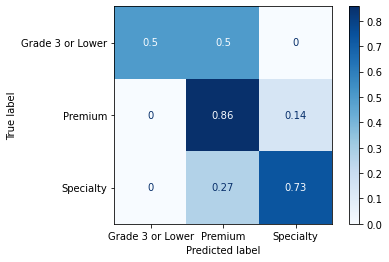

In [53]:
evaluation_block(gbc)

In [54]:
save_scores(gbc, 'Gradient Boosting Untuned')

### 5.2 Tuning Hyperparameters

In [55]:
#Check out parameters currently in use
print('Parameters currently in use:\n')
pprint(gbc.get_params())

Parameters currently in use:

{'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'deviance',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'random_state': None,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}


### most important parameters are:
Criterion: The loss function used to find the optimal feature and threshold to split the data

learning_rate: this parameter scales the contribution of each tree

max_depth: the maximum depth of each tree

n_estimators: the number of trees to construct

init: the initial estimator. By default, it is the log(odds) converted to a probability

In [56]:
param_grid = {  'criterion' : ['friedman_mse', 'mse', 'mae'],
                'n_estimators' : [1, 2, 4, 8, 16, 32, 64, 100, 200],
                'max_depth' : np.linspace(1, 32, 32, endpoint=True),
                'learning_rate' : [1, 0.5, 0.25, 0.1, 0.05, 0.01],
                'min_samples_split' : np.linspace(0.1, 1.0, 10, endpoint=True),
                'min_samples_leaf' : np.linspace(0.1, 0.5, 5, endpoint=True),
                'max_features' : list(range(1,coffee3.shape[1]))
             }

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Best Parameters based on Randomized Search CV: {'n_estimators': 32, 'min_samples_split': 0.1, 'min_samples_leaf': 0.30000000000000004, 'max_features': 6, 'max_depth': 29.0, 'learning_rate': 0.25, 'criterion': 'friedman_mse'}
Best score:  0.6967757230915126
Train - Accuracy: 0.6875
Test - Accuracy: 0.7895
Train - F1: 0.6684
Test - F1: 0.7867
Validation - Classification report
                   precision    recall  f1-score   support

Grade 3 or Lower       1.00      0.50      0.67         2
         Premium       0.78      0.86      0.82        21
       Specialty       0.79      0.73      0.76        15

        accuracy                           0.79        38
       macro avg       0.86      0.70      0.75        38
    weighted avg       0.80      0.79      0.79        38



<Figure size 648x648 with 0 Axes>

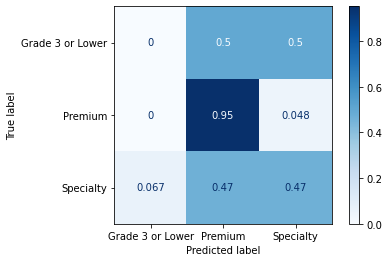

In [57]:
rand_cv(gbc, param_grid, 'Gradient Boosting RandomSearch')

In [58]:
results.sort_values('test_accuracy', ascending = False).head(15)

,model,name,train_accuracy,test_accuracy,train_f1,test_f1
9,"(DecisionTreeClassifier(max_features='auto', random_state=1165313289), DecisionTreeClassifier(ma...",Random Forest Balanced Subsample,0.9911,0.8421,0.9911,0.8421
7,"(DecisionTreeClassifier(max_features='auto', random_state=1165313289), DecisionTreeClassifier(ma...",Random Forest Out of the Box,0.9911,0.8421,0.9911,0.8421
8,"(DecisionTreeClassifier(max_features='auto', random_state=1165313289), DecisionTreeClassifier(ma...",Random Forest Balanced,0.9911,0.8421,0.9911,0.8421
19,"RandomizedSearchCV(cv=3, estimator=GradientBoostingClassifier(), n_iter=100,\n ...",Gradient Boosting RandomSearch,0.6875,0.7895,0.6875,0.7895
18,"([DecisionTreeRegressor(criterion='friedman_mse', max_depth=3,\n random_sta...",Gradient Boosting Untuned,0.9732,0.7895,0.9732,0.7895
16,"(DecisionTreeClassifier(max_features='auto', random_state=1165313289), DecisionTreeClassifier(ma...","RandomForestClassifier(random_state=10) with top Index(['Variety_Caturra', 'Variety_Catuai', 'Co...",0.9821,0.7895,NaN,NaN
14,"(DecisionTreeClassifier(max_features='auto', random_state=1165313289), DecisionTreeClassifier(ma...","RandomForestClassifier(random_state=10) with top Index(['Country of Origin_Colombia', 'Moisture'...",0.9464,0.7368,NaN,NaN
17,"(DecisionTreeClassifier(max_features='auto', random_state=1165313289), DecisionTreeClassifier(ma...","RandomForestClassifier(class_weight='balanced_subsample', random_state=10) with top Index(['Vari...",0.9821,0.7105,NaN,NaN
15,"(DecisionTreeClassifier(max_features='auto', random_state=1165313289), DecisionTreeClassifier(ma...","RandomForestClassifier(class_weight='balanced_subsample', random_state=10) with top Index(['Coun...",0.9464,0.7105,NaN,NaN
0,LogisticRegression(),Log Reg Out of the Box,0.7589,0.7105,0.7589,0.7105


# 6. Catboost Model

Pros 
* Good quality with default parameters
* Sophisticated Categorical features support
* Model analysis tools

In [60]:
#use df with categorical features (no need to label encode)
coffee3 = pd.read_csv('coffee3.csv')
coffee3 = coffee3.drop(columns=['Unnamed: 0'])

In [61]:
coffee3.columns

Index(['Country of Origin', 'Variety', 'Mean Altitude (m)', 'Harvest Year',
       'Processing Method', 'Moisture', 'Color', 'Coffee_Grade'],
      dtype='object')

In [62]:
X = coffee3.drop('Coffee_Grade', axis=1)        
y  = coffee3['Coffee_Grade']
X.shape, y.shape

((150, 7), (150,))

Now we will declare the cat feature which holds the categorical values present on train data set .

In [63]:
categorical_features_indices = np.where(X.dtypes != np.float)[0]
categorical_features_indices

array([0, 1, 3, 4, 6])

In [64]:
#find class weights for class_wights parameter
round( coffee3['Coffee_Grade'].value_counts(normalize=True) * 100 , 2)

Premium             52.67
Specialty           38.67
Grade 3 or Lower     8.67
Name: Coffee_Grade, dtype: float64

### 6.1 CatBoost - Out of the Box

Because we have 3 classes, we will be using the Cat Boost Classifier model with loss_function = 'MultiClass'

In [65]:
cat = CatBoostClassifier(loss_function='MultiClass', class_weights = [(100-8.67), (100-52.67), (100-38.67)], eval_metric = 'Accuracy')

In [66]:
#split data
X_cat_train, X_cat_test, y_cat_train, y_cat_test = train_test_split(X, y, test_size = 0.25)

cat.fit(X_cat_train, y_cat_train, cat_features=categorical_features_indices, eval_set=(X_cat_test, y_cat_test), verbose=False)

In [67]:
print(cat.get_best_score())

{'learn': {'Accuracy': 1.0, 'MultiClass': 0.026577658603717195}, 'validation': {'Accuracy': 0.6560311588317315, 'MultiClass': 0.8314568738600726}}


In [68]:
y_pred = cat.predict(X_cat_test)
y_tr_pred = cat.predict(X_cat_train)

<Figure size 648x648 with 0 Axes>

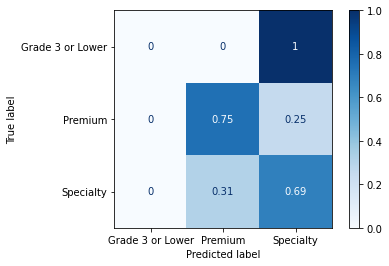

In [69]:
#create confusion matrix
plt.figure(figsize=(9,9))
plot_confusion_matrix(cat, X_cat_test, y_cat_test, normalize='true', cmap = 'Blues')
plt.show()

In [70]:
train_acc = round(accuracy_score(y_cat_train,y_tr_pred),4)
test_acc = round(accuracy_score(y_cat_test,y_pred),4)
print(train_acc)
print(test_acc)

0.6786
0.6842


### 6.2 Tuning Hyperparameters

In [134]:
param_grid = {'iterations' : [1000,3000],
                'depth' : [4,6,8],     
                'early_stopping_rounds' : [10, 20, 50]
             }